In [2]:
# Imports
from pathlib import Path
import matplotlib as mpl
import pickle
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import torch
from neuralhydrology.nh_run import start_run, eval_run, finetune

In [3]:
mpl.rcParams["grid.color"] = "#eeeeee"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 11})

### Pretraining

In [3]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("750_basins.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("750_basins.yml"), gpu=-1)

2024-09-26 17:06:36,523: Logging to /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/multi_basin_multi_forcing/DE4_riefensbeek_soese/runs/cudalstm_750_basins_2609_170636/output.log initialized.
2024-09-26 17:06:36,524: ### Folder structure created at /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/multi_basin_multi_forcing/DE4_riefensbeek_soese/runs/cudalstm_750_basins_2609_170636
2024-09-26 17:06:36,524: ### Run configurations for cudalstm_750_basins
2024-09-26 17:06:36,524: experiment_name: cudalstm_750_basins
2024-09-26 17:06:36,525: train_basin_file: 750_basins_list.txt
2024-09-26 17:06:36,525: validation_basin_file: 750_basins_list.txt
2024-09-26 17:06:36,525: test_basin_file: 750_basins_list.txt
2024-09-26 17:06:36,525: train_start_date: 1951-01-01 00:00:00
2024-09-26 17:06:36,526: train_end_date: 2015-09-30 00:00:00
2024-09-26 17:06:36,526: validation_start_date: 2015-10-01 00:00:00
2024-09-26 17:06:36,526: validation_end_date: 2018-09-30 00:00:00
2024-09-26 17:06:36,527: tes

In [4]:
# Load validation results from the last epoch
run_dir = Path("runs/cudalstm_750_basins_2609_170636")
df = pd.read_csv(run_dir / "validation" / "model_epoch012" / "validation_metrics.csv", dtype={'basin': str})
df = df.set_index('basin')

# Compute the median NSE from all basins, where discharge observations are available for that period
print(f"Median NSE of the validation period {df['NSE'].median():.3f}")

# Select the basin of choice:
basin = 'DE4'
print(f"Selected basin: {basin} with an NSE of {df.loc[df.index == basin, 'NSE'].values[0]:.3f}")

Median NSE of the validation period 0.849
Selected basin: DE4 with an NSE of 0.824


In [5]:
regional_dir = Path("runs/cudalstm_750_basins_2609_170636")
eval_run(regional_dir, period="test")

# Evaluation: 100%|██████████| 750/750 [12:26<00:00,  1.01it/s]


In [6]:
# Load Pretraining results for comparison
multi_basin_dir = Path("runs/cudalstm_750_basins_2609_170636")
with open(multi_basin_dir / "test" / "model_epoch015" / "test_results.p", "rb") as fp:
    results_multi_basin = pickle.load(fp)

# Extract observations and simulations
qobs_multi_basin = results_multi_basin['DE4']['1D']['xr']['discharge_vol_obs']
qsim_multi_basin = results_multi_basin['DE4']['1D']['xr']['discharge_vol_sim']

### Finetuning

In [14]:
basin = 'DE4'
# Add the path to the pre-trained model to the finetune config
with open("finetune.yml", "a") as fp:
    fp.write(f"\nbase_run_dir: {run_dir.absolute()}")
    
# Create a basin file with the basin we selected above
with open("finetune_basin.txt", "w") as fp:
    fp.write(basin)

In [15]:
finetune(Path("finetune.yml"))

2024-09-27 09:58:26,903: Logging to /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/multi_basin_multi_forcing/DE4_riefensbeek_soese/runs/cudalstm_750_basins_finetuned_2709_095826/output.log initialized.
2024-09-27 09:58:26,903: ### Folder structure created at /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/multi_basin_multi_forcing/DE4_riefensbeek_soese/runs/cudalstm_750_basins_finetuned_2709_095826
2024-09-27 09:58:26,903: ### Start finetuning with pretrained model stored in /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/multi_basin_multi_forcing/DE4_riefensbeek_soese/runs/cudalstm_750_basins_2609_170636
2024-09-27 09:58:26,903: ### Run configurations for cudalstm_750_basins_finetuned
2024-09-27 09:58:26,903: batch_size: 256
2024-09-27 09:58:26,903: clip_gradient_norm: 1
2024-09-27 09:58:26,904: commit_hash: dd0f70b
2024-09-27 09:58:26,904: data_dir: ../../../data/camels_de
2024-09-27 09:58:26,904: dataset: camels_de
2024-09-27 09:58:26,904: device: cuda:0
2024-09-27 09:58:26,9

In [7]:
finetune_dir = Path("runs/cudalstm_750_basins_finetuned_2709_095826")
eval_run(finetune_dir, period="test")

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


In [8]:
# load test results of the finetuned model
df_finetuned = pd.read_csv(finetune_dir / "test/model_epoch020/test_metrics.csv", dtype={'basin': str})
df_finetuned = df_finetuned.set_index("basin")
    
# extract basin performance
finetune_nse = df_finetuned.loc[df_finetuned.index == basin, "NSE"].values[0]
print(f"Performance after finetuning: {finetune_nse:.3f}")

Performance after finetuning: 0.865


In [9]:
with open(finetune_dir / "test" / "model_epoch020" / "test_results.p", "rb") as fp:
    results_finetuned = pickle.load(fp)
    
results_finetuned.keys()
# Extract observations and simulations
qobs_finetuned = results_finetuned['DE4']['1D']['xr']['discharge_vol_obs']
qsim_finetuned = results_finetuned['DE4']['1D']['xr']['discharge_vol_sim']

In [10]:
# Load Single basin results for comparison
single_basin_dir = Path("../../single_basin_multi_forcing_MDN/DE4_riefensbeek_soese/runs/single_basin_multi_forcing_mdn_1809_141256")
with open(single_basin_dir / "test" / "model_epoch075" / "test_results.p", "rb") as fp:
    results_single_basin = pickle.load(fp)
    
results_single_basin.keys()
# Extract observations and simulations
qobs_single_basin = results_single_basin['DE4']['1D']['xr']['discharge_vol_obs']
qsim_single_basin = results_single_basin['DE4']['1D']['xr']['discharge_vol_sim']

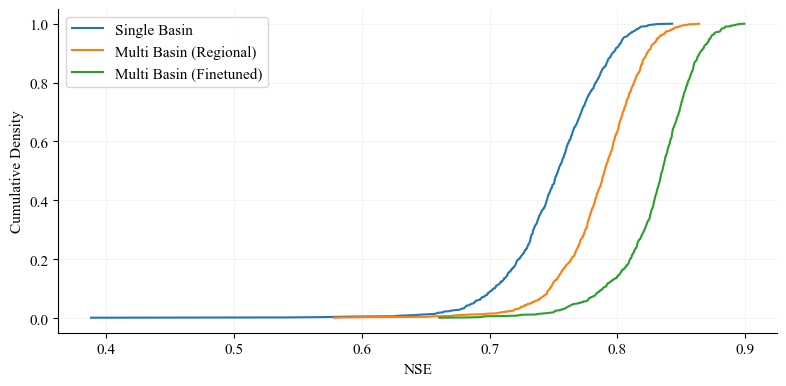

In [27]:
# Define the NSE calculation function
def nse(obs, sim):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE) between observed and simulated data.
    
    Parameters:
    obs (np.ndarray): Observed data array of shape (823,)
    sim (np.ndarray): Simulated data array of shape (823,)
    
    Returns:
    float: NSE value
    """
    # Ensure inputs are 1D numpy arrays
    obs = np.asarray(obs).flatten()
    sim = np.asarray(sim).flatten()
    
    # Calculate numerator and denominator for NSE
    denominator = np.sum((obs - np.mean(obs))**2)
    numerator = np.sum((sim - obs)**2)
    
    # Calculate NSE
    value = 1 - numerator / denominator
    return value

# Load or assign the observed data (shape: 823 x 1)
obs_data = qobs_finetuned  # xarray.DataArray of shape (823, 1)
obs = obs_data.values.flatten()  # Convert to 1D numpy array of shape (823,)

# Load or assign the simulated data for finetuned model (shape: 823 x 1 x 7500)
sim_data_finetuned = qsim_finetuned  # xarray.DataArray of shape (823, 1, 7500)

# Load or assign the simulated data for single basin model (shape: 823 x 1 x 7500)
sim_data_single_basin = qsim_single_basin  # xarray.DataArray of shape (823, 1, 7500)

# Load or assign the simulated data for multi basin model (shape: 823 x 1 x 7500)
sim_data_multi_basin = qsim_multi_basin # xarray.DataArray of shape (823, 1, 7500)

# Number of samples (should be 7500)
num_samples = sim_data_finetuned.shape[2]

# Initialize lists to store NSE values
nse_values_finetuned = []
nse_values_single_basin = []
nse_values_multi_basin = []

# Loop over each sample to calculate NSE for finetuned model
for i in range(num_samples):
    sim_sample_finetuned = sim_data_finetuned[:, 0, i]
    nse_i_finetuned = nse(obs, sim_sample_finetuned)
    nse_values_finetuned.append(nse_i_finetuned)

# Loop over each sample to calculate NSE for single basin model
for i in range(num_samples):
    sim_sample_single_basin = sim_data_single_basin[:, 0, i]
    nse_i_single_basin = nse(obs, sim_sample_single_basin)
    nse_values_single_basin.append(nse_i_single_basin)

# Loop over each sample to calculate NSE for multi basin model
for i in range(num_samples):
    sim_sample_multi_basin = sim_data_multi_basin[:, 0, i]
    nse_i_multi_basin = nse(obs, sim_sample_multi_basin)
    nse_values_multi_basin.append(nse_i_multi_basin)

# Convert the lists of NSE values to numpy arrays
nse_values_finetuned = np.array(nse_values_finetuned)
nse_values_single_basin = np.array(nse_values_single_basin)
nse_values_multi_basin = np.array(nse_values_multi_basin)

# Sort the NSE values in ascending order
nse_sorted_finetuned = np.sort(nse_values_finetuned)
nse_sorted_single_basin = np.sort(nse_values_single_basin)
nse_sorted_multi_basin = np.sort(nse_values_multi_basin)

# Calculate cumulative probabilities for the ECDF
cum_probs_finetuned = np.arange(1, len(nse_sorted_finetuned) + 1) / len(nse_sorted_finetuned)
cum_probs_single_basin = np.arange(1, len(nse_sorted_single_basin) + 1) / len(nse_sorted_single_basin)
cum_probs_multi_basin = np.arange(1, len(nse_sorted_multi_basin) + 1) / len(nse_sorted_multi_basin)

# Plot the ECDFs
plt.figure(figsize=(8, 4))
plt.plot(nse_sorted_multi_basin, cum_probs_multi_basin, linestyle='-', label='Multi Basin (Regional)')
plt.plot(nse_sorted_finetuned, cum_probs_finetuned, linestyle='-', label='Multi Basin (Finetuned)')
plt.plot(nse_sorted_single_basin, cum_probs_single_basin, linestyle='-', label='Single Basin')
plt.xlabel('NSE')
plt.ylabel('Cumulative Density')
# plt.title('ECDF of NSE Values for the Soese Catchment')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
# save as png in high resolution
# plt.savefig("ecdf_nse_soese.png", dpi=300)
plt.show()